# N-arm Antenna Position Calibration

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on N arms which are placed approximately equally apart.  This notebook will use measurements to infer the actual layout of the antennas.

We assume that one arm is known to point in a certain direction. This is usually found by a separate calibration step by signting along arms to convenient geographic locations.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]

known_angles = [(5, -101.2)]   # Geographic angle of one of the arms.

In [3]:
# pip install pandas
# pip install odfpy

import pandas as pd

N_ant = 24
N_arms = 5

cols = [f"A {i}" for i in range(N_ant)]
data = pd.read_excel('antenna_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

A 0      695.0
A 1     2555.0
A 2     1120.0
A 3     2045.0
A 4     1730.0
A 5     1813.0
A 6     2575.0
A 7      260.0
A 8      565.0
A 9      943.0
A 10    2565.0
A 11     680.0
A 12    1530.0
A 13    1204.0
A 14    1944.0
A 15     875.0
A 16    2570.0
A 17     350.0
A 18    2285.0
A 19    1280.0
A 20    2530.0
A 21    2233.0
A 22    1810.0
A 23    1283.0
Name: 0, dtype: float64

## Finding the antennas

This is done by measuring the distance from each antenna to x0 as well as each other antenna. The distance $m_0$ are the measurements to $x_0$. The array m_ij are the distances between antennas.

In [4]:
m_0 = np.zeros(N_ant)
m_ij = np.zeros((N_ant,N_ant))

radius = data.loc[0]

for i in range(N_ant):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [5]:
for i in range(N_ant):
    for j in range(N_ant):
        if not np.isnan(m_ij[i,j]):
            m_ij[j,i] = m_ij[i,j]

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [6]:
def get_angle(x,y):
    ang = np.degrees(np.arctan2(y,x))
    return np.unwrap([90-ang], period= 360)[0]

def get_xy(r, theta):
    rad = np.radians(theta)
    x = r*np.sin(rad)
    y = r*np.cos(rad)
    return x,y

for theta in np.arange(0,360, 10):
    x,y = get_xy(1, theta)
    th2 = get_angle(x,y)
    x2, y2 = get_xy(1, th2)
    if np.abs(x2 - x) > 1e-6:
        print(x2,x)


In [7]:
import requests
import json    

def get_data(path):
    server = "https://tart.elec.ac.nz/rhodes"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

if True:
    with open('rhodes_24_opt.json', "r") as f:
        data = f.read()
    cal_json = json.loads(data)
    print(cal_json)
    arm_angles = np.array(cal_json['arm_degrees'])
    narms = cal_json['num_arms']
    arms = cal_json['arms']
    current_pos = []
    for arm_angle,arm in zip(arm_angles, arms):
        print(arm_angle, arm)
        r = np.array(arm)
        arm_x, arm_y = get_xy(r, arm_angle)
        for x,y in zip(arm_x, arm_y):
            current_pos.append([x,y])
    current_pos = np.array(current_pos)
else:
    current_pos = get_pos()
    json_result = {}
    json_result["antenna_positions"] = current_pos.tolist()
    print(json.dumps(json_result, indent=4, separators=(',', ': ')))

{'C/N': 2.158123728118006, 'arm_degrees': [0.0, 72.0, 144.0, 216.0, 288.0], 'arms': [[0.6529630237476174, 2.504432694886343, 1.073494591195416, 2.0005486285280463, 1.693181081287429], [1.7817801673973575, 2.5479706468791354, 0.24027311461115142, 0.5448087496619634, 0.9209845465458897], [2.54993417924799, 0.7030967569347759, 1.5336789571128613, 1.2116849949441444, 1.932751799958924], [0.8609740214161916, 2.5468131744184697, 0.3521255703988069, 2.2409579872406376, 1.2609873402646041], [2.4973866033909307, 2.191993817667368, 1.7956789837968319, 1.2717328395565333]], 'entropy': 3.8594732373100027, 'fov_degrees': 160.0, 'num_arms': 5, 'penalty': 0.05830674870939684, 'radius': 2.55, 'radius_lower': 0.20000000298023224, 'res_arcmin': 180.0, 'spacing': 0.30000001192092896}
0.0 [0.6529630237476174, 2.504432694886343, 1.073494591195416, 2.0005486285280463, 1.693181081287429]
72.0 [1.7817801673973575, 2.5479706468791354, 0.24027311461115142, 0.5448087496619634, 0.9209845465458897]
144.0 [2.549934

## Parameter Mapping

The parameters will be 24 radius measurements and three angle measurements. The first arm is assumed to be at angle zero. The first task is to get these parameters from the initial position estimate.

In [8]:
N_arm = 5
N_ant = 24

arm_angles = np.degrees(arm_angles)
print(f"Arm Angles: {arm_angles}")

arm_angle_indices = np.zeros(N_ant, dtype=int)
arms = np.array_split(np.arange(N_ant, dtype=int), N_arm)
print(arms)
for i in range(N_arm):
    arm_angle_indices[arms[i]] = i

print(arm_angle_indices)

def split_param(x):
    arm_angles = x[0:N_arm]
    radii = x[N_arm:N_ant+N_arm]
    
    return arm_angles, radii

def p(x, i): # Coordinates for the ith antenna from parameters x
    arm_angles, radii = split_param(x)
    
    r = radii[i]
    ai = arm_angle_indices[i]
    
    x,y = get_xy(r, arm_angles[ai])
    return [x,y]

Arm Angles: [    0.          4125.29612494  8250.59224988 12375.88837483
 16501.18449977]
[array([0, 1, 2, 3, 4]), array([5, 6, 7, 8, 9]), array([10, 11, 12, 13, 14]), array([15, 16, 17, 18, 19]), array([20, 21, 22, 23])]
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4]


In [9]:
def plot_ant(ax, p):
    for i in range(0,p.shape[0]):
        #print(p[i])
        ax.text(pos_i[i,0], pos_i[i,1],f"{i}")

Arm angle index 0, 0.0
Arm angle index 0, 0.0
Arm angle index 0, 0.0
Arm angle index 0, 0.0
Arm angle index 0, 0.0
Arm angle index 1, 72.0
Arm angle index 1, 72.0
Arm angle index 1, 72.0
Arm angle index 1, 72.0
Arm angle index 1, 72.0
Arm angle index 2, 144.0
Arm angle index 2, 144.0
Arm angle index 2, 144.0
Arm angle index 2, 144.0
Arm angle index 2, 144.0
Arm angle index 3, 216.0
Arm angle index 3, 216.0
Arm angle index 3, 216.0
Arm angle index 3, 216.0
Arm angle index 3, 216.0
Arm angle index 4, -72.00000000000003
Arm angle index 4, -72.00000000000003
Arm angle index 4, -72.00000000000003
Arm angle index 4, -72.00000000000003
initial arm angles: [  0.  72. 144. 216. -72.]


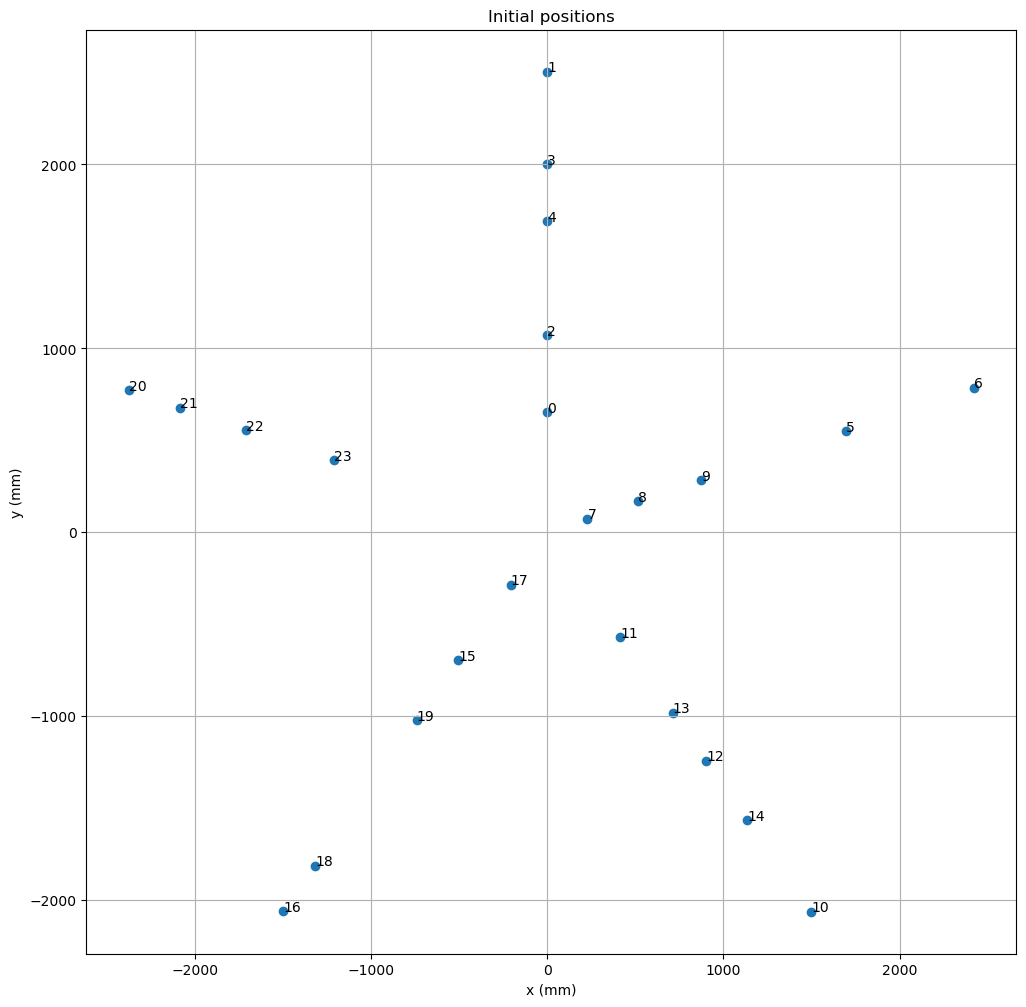

In [10]:
n_param = N_ant + N_arm

initial_guess = np.zeros(n_param)
initial_arm_angles = np.zeros(N_arm)
for i in range(N_ant):
    x,y = current_pos[i][0:2]*1000
    
    r = np.sqrt(x**2 + y**2)
    theta = get_angle(x,y)
    
    ai = arm_angle_indices[i]
    print(f"Arm angle index {ai}, {theta}")
    initial_guess[ai] = theta
    initial_guess[N_arm+i] = r
    initial_arm_angles[ai] = theta
    
    # print(x,y, r, theta)
print(f"initial arm angles: {initial_arm_angles}")
pos_i = current_pos*1000
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1])
plot_ant(ax, pos_i)
ax.grid(True)
ax.set_title('Initial positions')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
plt.savefig('initial_positions.png')
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [11]:
initial_guess

array([   0.        ,   72.        ,  144.        ,  216.        ,
        -72.        ,  652.96302375, 2504.43269489, 1073.4945912 ,
       2000.54862853, 1693.18108129, 1781.7801674 , 2547.97064688,
        240.27311461,  544.80874966,  920.98454655, 2549.93417925,
        703.09675693, 1533.67895711, 1211.68499494, 1932.75179996,
        860.97402142, 2546.81317442,  352.1255704 , 2240.95798724,
       1260.98734026, 2497.38660339, 2191.99381767, 1795.6789838 ,
       1271.73283956])

In [12]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

center = [0,0]

def radius_model(x):
    ret = []
    
    for i in range(N_ant):
        p_i = p(x,i)
        ret.append(dist(center, p_i))
        
    return np.array(ret)

non_nan_ij = []
non_nan_indices = []
for i in range(N_ant):
    for j in range(N_ant):
        if not np.isnan(m_ij[i,j]):
            non_nan_ij.append(m_ij[i,j])
            non_nan_indices.append([i,j])
non_nan_ij = np.array(non_nan_ij)
non_nan_indices = np.array(non_nan_indices)

def m_ij_model(x):
    ret = []
    for i in range(N_ant):
        p_i = p(x,i)

        for j in range(N_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret.append(dist(p_j, p_i))
                
    return np.array(ret)
    
def radius_residual(x):
    predict = radius_model(x)
    return predict - radius

def m_ij_residual(x):
    predict = m_ij_model(x)
    return predict - non_nan_ij


def f(x):
    ret = 0
    for i in range(N_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(N_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

def f(x):
    # This is the final criterion for optimality. The sum of squared residuals.
    ret = np.sum(radius_residual(x)**2)
    ret += np.sum(m_ij_residual(x)**2)
    #ret += (100*x[0])**2
    return ret

print(f(initial_guess))

178931.16352158404


We can see that the initial value of this optimality condition is about 600,000.

In [13]:
bnd = [[0, 5000]]*n_param


for i in range(N_arm):
    bnd[i] = [-360, 360]
    
eps = 0.01
for i, theta in known_angles:
    bnd[i-1] = [theta - eps, theta + eps]

res = minimize(f, initial_guess, bounds=bnd, tol=1e-8)
res

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 297.4506236256219
        x: [-2.951e+01  4.253e+01 ...  1.811e+03  1.282e+03]
      nit: 368
      jac: [ 2.796e-02 -1.410e-02 ...  4.093e-03 -1.686e-02]
     nfev: 12030
     njev: 401
 hess_inv: <29x29 LbfgsInvHessProduct with dtype=float64>

In [14]:
res_arm_angles, res_radii = split_param(res.jac)
for i in range(N_arm):
    print(f"  Arm {i}:\tJac: {res_arm_angles[i]:06.2f}")

print("Antennas")
for i in range(N_ant):
    print(f"  Ant {i}:\tJac: {res_radii[i]:06.2f}")

  Arm 0:	Jac: 000.03
  Arm 1:	Jac: -00.01
  Arm 2:	Jac: 000.02
  Arm 3:	Jac: -00.02
  Arm 4:	Jac: -00.01
Antennas
  Ant 0:	Jac: 000.03
  Ant 1:	Jac: 000.02
  Ant 2:	Jac: 000.00
  Ant 3:	Jac: -00.01
  Ant 4:	Jac: -00.00
  Ant 5:	Jac: 000.01
  Ant 6:	Jac: 000.01
  Ant 7:	Jac: -00.00
  Ant 8:	Jac: 000.00
  Ant 9:	Jac: 000.02
  Ant 10:	Jac: 000.04
  Ant 11:	Jac: 000.00
  Ant 12:	Jac: 000.00
  Ant 13:	Jac: 000.00
  Ant 14:	Jac: -00.00
  Ant 15:	Jac: -00.01
  Ant 16:	Jac: -00.01
  Ant 17:	Jac: -00.00
  Ant 18:	Jac: -00.00
  Ant 19:	Jac: -00.01
  Ant 20:	Jac: 000.01
  Ant 21:	Jac: 000.00
  Ant 22:	Jac: 000.00
  Ant 23:	Jac: -00.02


The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [15]:
arm_angles, radii = split_param(res.x)
print(arm_angles)
print(radii)

[ -29.51230273   42.53350708  114.68297179  186.77618507 -101.19399573]
[ 698.2171048  2554.98930075 1117.08838555 2043.80991405 1728.69030246
 1815.45274499 2573.0554245   259.90289546  564.22784697  942.78742437
 2566.44300881  678.98569171 1529.5363347  1207.50933231 1943.68655375
  874.32121571 2576.20217219  352.06797216 2288.30738538 1281.03843082
 2528.25311193 2233.10435002 1810.58817505 1282.17801452]


In [16]:
arm_angles, radii = split_param(res.x)

pos = np.array([p(res.x, i) for i in range(N_ant)])

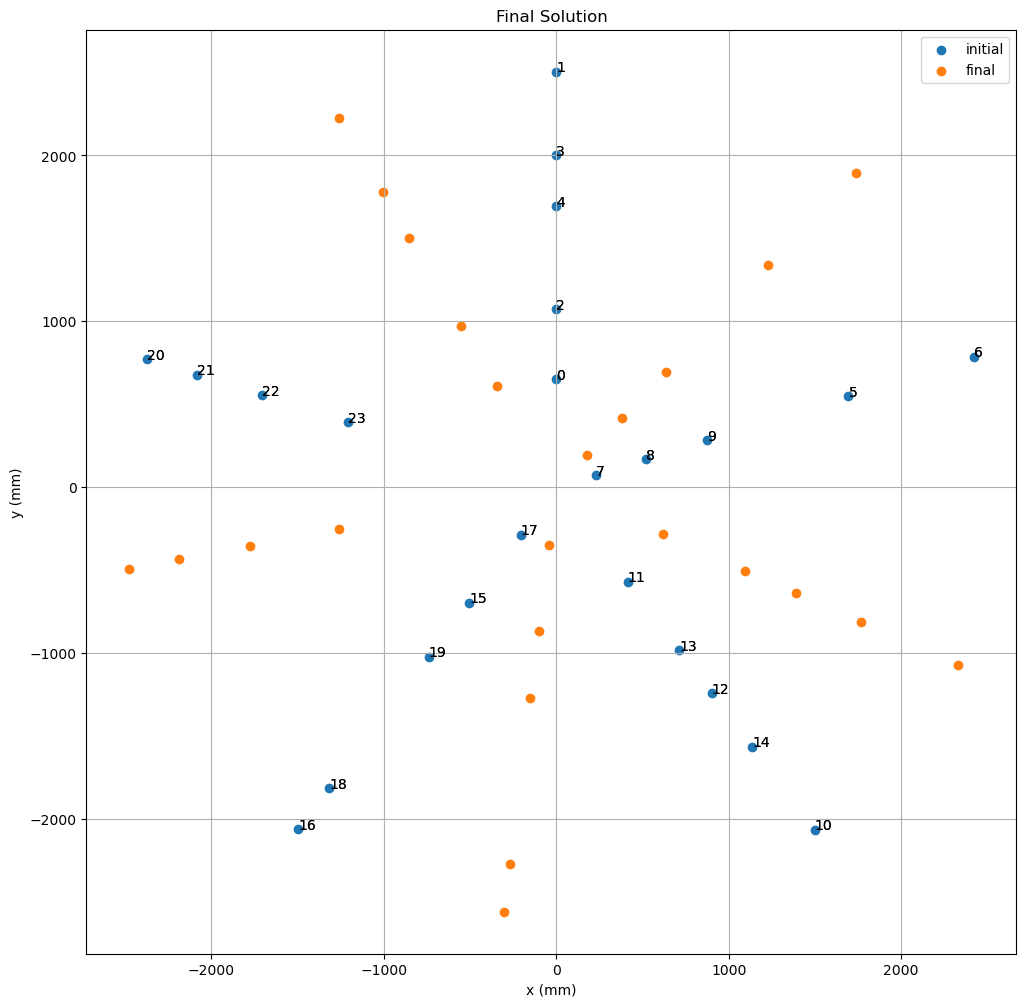

In [17]:
fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(pos_i[:,0], pos_i[:,1], label='initial')
ax.scatter(pos[:,0], pos[:,1], label='final')
plot_ant(ax, pos_i)
plot_ant(ax, pos)

ax.grid(True)
ax.set_title('Final Solution')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.legend()
plt.savefig('final_positions.png')
plt.show()

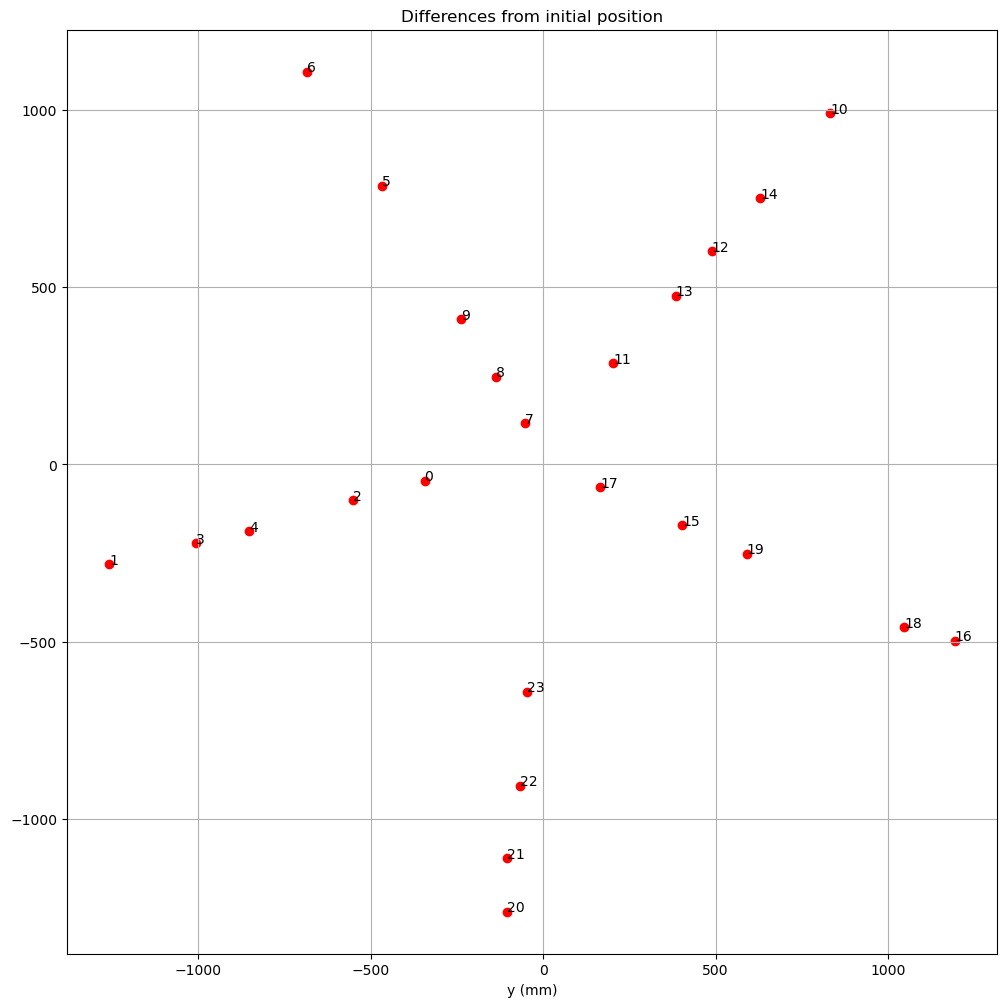

In [18]:
# Differences plot
diff = pos - pos_i[:,0:2]


fig, ax = plt.subplots(figsize=(12,12))

ax.scatter(diff[:,0], diff[:,1], color='red')

for i in range(0,diff.shape[0]):
    ax.text(diff[i,0], diff[i,1],f"{i}")

ax.grid(True)
ax.set_title("Differences from initial position")
ax.set_xlabel('x (mm)')
ax.set_xlabel('y (mm)')
plt.savefig('differences.png')
plt.show()

In [19]:
# Residual plot
rres = radius_residual(res.x)
rres

A 0     3.217105
A 1    -0.010699
A 2    -2.911614
A 3    -1.190086
A 4    -1.309698
A 5     2.452745
A 6    -1.944576
A 7    -0.097105
A 8    -0.772153
A 9    -0.212576
A 10    1.443009
A 11   -1.014308
A 12   -0.463665
A 13    3.509332
A 14   -0.313446
A 15   -0.678784
A 16    6.202172
A 17    2.067972
A 18    3.307385
A 19    1.038431
A 20   -1.746888
A 21    0.104350
A 22    0.588175
A 23   -0.821985
Name: 0, dtype: float64

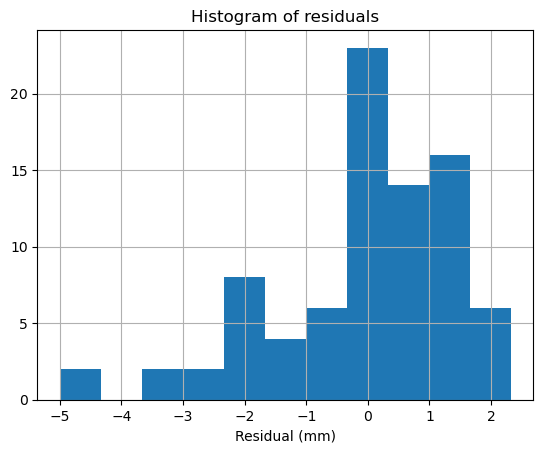

In [20]:
# ij resdual
ijres = m_ij_residual(res.x)
plt.hist(ijres, bins='fd');
plt.title("Histogram of residuals")
plt.xlabel("Residual (mm)")
plt.grid(True)
plt.savefig("residual_histogram.png")

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [21]:
absres = np.abs(ijres)
p95 = np.percentile(absres, 95)

print(f"95th percentile of residuals is {p95:4.2f} mm")
ijres_matrix = np.zeros_like(m_ij)
for r, i, j in zip(ijres, non_nan_indices[:,0], non_nan_indices[:,1]):
    if np.abs(r) > p95:
        print(f" res[{i},{j}] = {r:3.1f}")
    ijres_matrix[i,j] = r
    


95th percentile of residuals is 2.95 mm
 res[8,10] = -5.0
 res[8,16] = -3.1
 res[10,8] = -5.0
 res[16,8] = -3.1


## Output best estimates

Write some json files...

In [22]:
result = np.zeros((N_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.344,  0.608,  0.   ],
       [-1.259,  2.223,  0.   ],
       [-0.55 ,  0.972,  0.   ],
       [-1.007,  1.779,  0.   ],
       [-0.852,  1.504,  0.   ],
       [ 1.227,  1.338,  0.   ],
       [ 1.739,  1.896,  0.   ],
       [ 0.176,  0.192,  0.   ],
       [ 0.381,  0.416,  0.   ],
       [ 0.637,  0.695,  0.   ],
       [ 2.332, -1.072,  0.   ],
       [ 0.617, -0.284,  0.   ],
       [ 1.39 , -0.639,  0.   ],
       [ 1.097, -0.504,  0.   ],
       [ 1.766, -0.812,  0.   ],
       [-0.103, -0.868,  0.   ],
       [-0.304, -2.558,  0.   ],
       [-0.042, -0.35 ,  0.   ],
       [-0.27 , -2.272,  0.   ],
       [-0.151, -1.272,  0.   ],
       [-2.48 , -0.491,  0.   ],
       [-2.191, -0.434,  0.   ],
       [-1.776, -0.351,  0.   ],
       [-1.258, -0.249,  0.   ]])

In [23]:
json_result = {}
json_result["antenna_positions"] = result.tolist()
print(json.dumps(json_result, indent=4, separators=(',', ': ')))

f = open("rhodes_antenna_positions.json", "w")
f.write(json.dumps(json_result))
f.close()


{
    "antenna_positions": [
        [
            -0.344,
            0.608,
            0.0
        ],
        [
            -1.259,
            2.223,
            0.0
        ],
        [
            -0.55,
            0.972,
            0.0
        ],
        [
            -1.007,
            1.779,
            0.0
        ],
        [
            -0.852,
            1.504,
            0.0
        ],
        [
            1.227,
            1.338,
            0.0
        ],
        [
            1.739,
            1.896,
            0.0
        ],
        [
            0.176,
            0.192,
            0.0
        ],
        [
            0.381,
            0.416,
            0.0
        ],
        [
            0.637,
            0.695,
            0.0
        ],
        [
            2.332,
            -1.072,
            0.0
        ],
        [
            0.617,
            -0.284,
            0.0
        ],
        [
            1.39,
            -0.639,
            0.0
 

The position file above is in a format suitable for uploading to the telescope api. There is a tool for this in the 'tart_tools' python package. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --file rhodes_antenna_positions.json --pw=xxxx
